In [1]:
# imports
# Audio processing
import librosa
# visualisation
import librosa.display as sound_display
import matplotlib.pyplot as plt
# Audio player
from IPython.display import Audio
# data processing
import numpy as np

In [2]:
%matplotlib inline

In [3]:
AUDIO_FILE = "../assets/sound/Koel.mp3"
samples, sample_rate = librosa.load(AUDIO_FILE, sr=None)

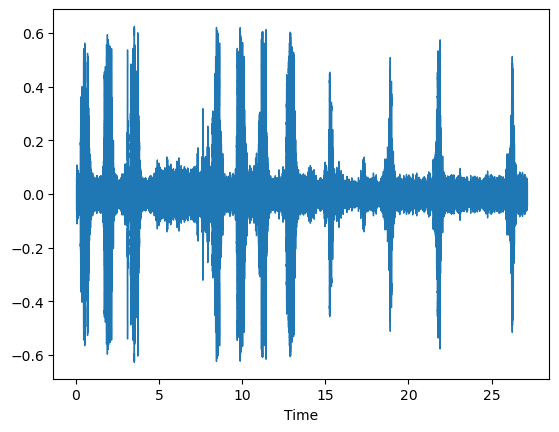

In [4]:
plt.Figure(figsize=(200,80))
sound_display.waveshow(samples,sr=sample_rate)
Audio(AUDIO_FILE)

C:\Users\Dell\AppData\Local\Temp\ipykernel_15248\1629701454.py:4: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  sound_display.specshow(sgram)


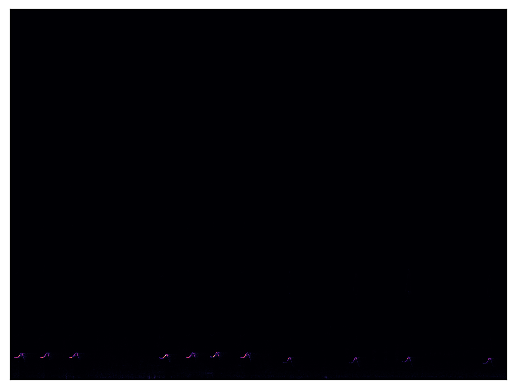

In [19]:
# regular spectogram
# Not much info can be obtained
sgram = librosa.stft(samples)
sound_display.specshow(sgram)

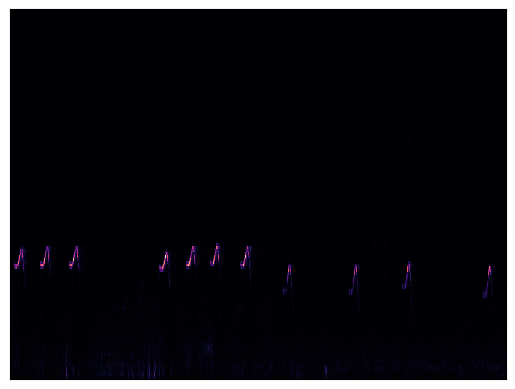

In [20]:
# using mel scale instead of freq in y-axis
# separating spectrogram into magnitude and phase component
smag, _ = librosa.magphase(sgram)
mel_scale_sgram = librosa.feature.melspectrogram(S=smag, sr=sample_rate)
sound_display.specshow(mel_scale_sgram)

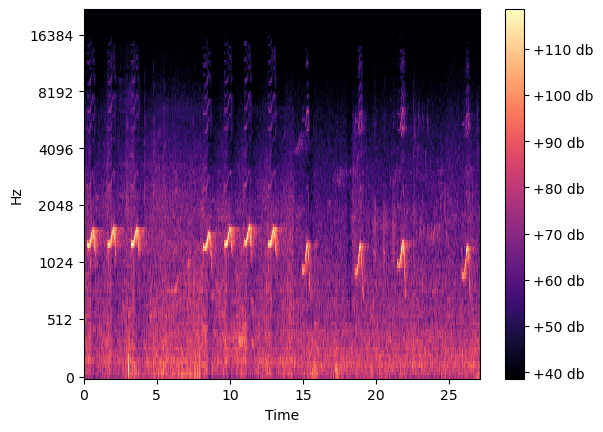

In [30]:
# using db scale instead amplitude
mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
sound_display.specshow(mel_sgram, x_axis="time", y_axis="mel", sr = sample_rate)
plt.colorbar(format="%+2.0f db")

# Project Work

## imports

In [1]:
import math, random

import torch
import torchaudio
from torchaudio import transforms

from IPython.display import Audio

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#from helpers.utils import sound_spec

In [2]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [3]:
%matplotlib inline

## Training Data

In [4]:
df = pd.read_csv("../assets/sample/UrbanSound8K/metadata/UrbanSound8K.csv")

In [5]:
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [6]:
df['class'].unique()

array(['dog_bark', 'children_playing', 'car_horn', 'air_conditioner',
       'street_music', 'gun_shot', 'siren', 'engine_idling', 'jackhammer',
       'drilling'], dtype=object)

In [7]:
relativePath ="../assets/sample/UrbanSound8K/audio/"+"fold"+df['fold'].astype(str)+"/"+df['slice_file_name']

In [8]:
df['relativePath'] = relativePath

In [9]:
df = df[['relativePath', 'classID']]

In [10]:
df.head()

,relativePath,classID
0,../assets/sample/UrbanSound8K/audio/fold5/1000...,3
1,../assets/sample/UrbanSound8K/audio/fold5/1002...,2
2,../assets/sample/UrbanSound8K/audio/fold5/1002...,2
3,../assets/sample/UrbanSound8K/audio/fold5/1002...,2
4,../assets/sample/UrbanSound8K/audio/fold5/1002...,2


## Data Preprocessing

### Read Audio File

In [11]:
def open(file_name):
    sig, sr = torchaudio.load(file_name)
    return (sig, sr)

In [12]:
sig, sr = open(df['relativePath'][0])

### Standardize channel length to 2

In [13]:
def rechannel(sig, sr, new_channel=2):
    # sig.shape returns (no. of channel, no. of frames)
    num_channel, _ = sig.shape
    
    # if channel is new_channel then don't do anything
    if(num_channel == new_channel): return (sig, sr)
    
    #if new_channel is 1
    if(new_channel == 1):
        resig = sig[:1, :]
    else:
        # copy mono channel to create two channel
        firstChannel = sig[:1, :]
        resig = torch.cat([firstChannel, firstChannel])
    
    return ((resig, sr))

### Standardize sampling rate to 44,100

In [14]:
def resample(sig, sr, new_sr = 44100):
    if(sr == new_sr): return (sig, sr)
    num_channel = sig.shape[0]
    
    resig = torchaudio.transforms.Resample(sr, new_sr)(sig[:1, :])
    if(num_channel > 1):
        resig2 = torchaudio.transforms.Resample(sr, new_sr)(sig[1:, :])
        resig = torch.cat([resig, resig2])
    return(resig, new_sr)

In [15]:
resample(sig, sr, 12000)

(tensor([[-0.0029, -0.0053, -0.0042,  ..., -0.0038, -0.0024, -0.0005],
         [-0.0029, -0.0052, -0.0041,  ..., -0.0038, -0.0025, -0.0006]]),
 12000)

### Resize to same length by padding or truncating

In [16]:
def resize(sig, sr, max_ms):
    num_channel, num_frame = sig.shape
    
    max_len = sr // 1000 *  max_ms
    
    if(max_len < num_frame):
        # truncating as max_len < num_frame
        resig = sig[:, : max_len]
    elif(max_len > num_frame):
        # padding at the beginning and end with silence
        begin_pad_length = np.randint(0, max_len - num_frame)
        end_pad_length = max_len - num_frame - begin_pad_length
        
        begin_pad = torch.zeros((num_channel, begin_pad_length))
        end_pad = torch.zeros((num_channel, end_pad_length))
        
        resig = torch.cat((begin_pad, sig, end_pad), 1)
    
    return ((resig, sr))

### Audio Data Augmentation

#### Time shift

In [17]:
def time_shift(sig, sr, shift_lim):
    num_frame = sig.shape[1]
    
    shift_amt = int(random.random() * shift_lim * num_frame)
    
    return (sig.roll(shift_amt), sr)

In [18]:
sig
print(sig,sig.shape)

tensor([[-4.5776e-03, -4.8828e-03, -4.6082e-03,  ..., -5.7983e-04,
         -4.2725e-04,  3.0518e-05],
        [-4.5166e-03, -4.7913e-03, -4.6082e-03,  ..., -7.3242e-04,
         -5.4932e-04, -3.0518e-05]]) torch.Size([2, 14004])


### Mel spectrogram

#### experimental on the basis of species

In [19]:
def spectrogram(sig, sr, n_mels = 64, n_fft = 1024, hop_length = None):
    # we can add more hyper parameter like min freq, max freq
    
    spec = transforms.MelSpectrogram(sr, n_mels = n_mels, n_fft = n_fft, hop_length = hop_length)(sig)
    mel_spec = transforms.AmplitudeToDB(top_db = 80)(spec)
    
    return mel_spec

### Spectrogram Augmentation

In [20]:
def spectrogram_augment(spec, max_mask_pct = 0.1, n_freq_mask = 1, n_time_mask = 1):
    _, n_mels, n_steps = spec.shape
    
    mask_val = spec.mean()
    aug_spec = spec
    
    freq_mask_param = max_mask_pct * n_mels
    for _ in range(n_freq_mask):
        aug_spec = transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_val)
    
    time_mask_param = max_mask_pct * n_steps
    for _ in range(n_time_mask):
        aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_val)
        
    return aug_spec

In [21]:
def sound_spec(spec):
    fig, axis = plt.subplots(1, 1)
    axis.set_xlabel(" time ")
    axis.set_ylabel(" mels ")
    axis.imshow(spec, origin="lower", aspect="auto")
    plt.show(block=False)

In [22]:
spec1 = spectrogram(sig, sr)

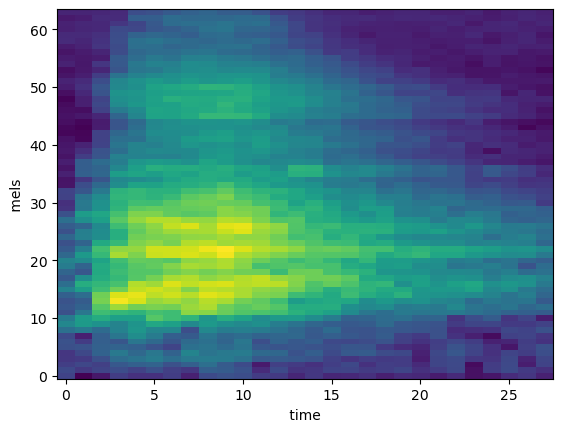

In [23]:
sound_spec(spec1[0])

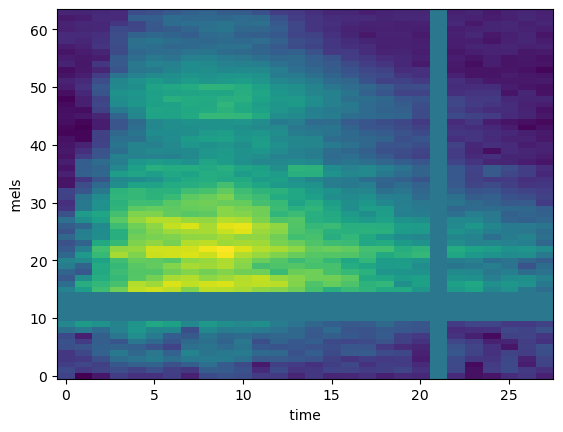

In [24]:
sound_spec(spectrogram_augment(spec1, n_time_mask=2)[0])

## Creating custom Dataset and DataLoader

In [43]:
class AudioUtils:
    @staticmethod
    def open(file_name):
        sig, sr = torchaudio.load(file_name)
        return (sig, sr)
    
    @staticmethod
    def rechannel(aud, new_channel=2):
        sig, sr = aud
        
        # sig.shape returns (no. of channel, no. of frames)
        num_channel, _ = sig.shape
    
        # if channel is new_channel then don't do anything
        if(num_channel == new_channel): return (sig, sr)
    
        #if new_channel is 1
        if(new_channel == 1):
            resig = sig[:1, :]
        else:
            # copy mono channel to create two channel
            firstChannel = sig[:1, :]
            resig = torch.cat([firstChannel, firstChannel])
    
        return ((resig, sr))
    
    @staticmethod
    def resample(aud, new_sr = 44100):
        sig, sr = aud
        if(sr == new_sr): return (sig, sr)
        num_channel = sig.shape[0]
        resig = torchaudio.transforms.Resample(sr, new_sr)(sig[:1, :])
        if(num_channel > 1):
            resig2 = torchaudio.transforms.Resample(sr, new_sr)(sig[1:, :])
            resig = torch.cat([resig, resig2])
        return(resig, new_sr)
    
    @staticmethod
    def resize(aud, max_ms = 4000):
        sig, sr = aud
        num_channel, num_frame = sig.shape
    
        max_len = sr // 1000 *  max_ms
    
        if(max_len < num_frame):
            # truncating as max_len < num_frame
            resig = sig[:, : max_len]
        elif(max_len > num_frame):
            # padding at the beginning and end with silence
            begin_pad_length = random.randint(0, max_len - num_frame)
            end_pad_length = max_len - num_frame - begin_pad_length
        
            begin_pad = torch.zeros((num_channel, begin_pad_length))
            end_pad = torch.zeros((num_channel, end_pad_length))
        
            resig = torch.cat((begin_pad, sig, end_pad), 1)
    
        return ((resig, sr))
    
    @staticmethod
    def time_shift(aud, shift_lim):
        sig, sr = aud
        num_frame = sig.shape[1]
    
        shift_amt = int(random.random() * shift_lim * num_frame)
    
        return (sig.roll(shift_amt), sr)
    
    @staticmethod
    def spectrogram(aud, n_mels = 64, n_fft = 1024, hop_length = None):
        # we can add more hyper parameter like min freq, max freq
        
        sig, sr = aud
        spec = transforms.MelSpectrogram(sr, n_mels = n_mels, n_fft = n_fft, hop_length = hop_length)(sig)
        mel_spec = transforms.AmplitudeToDB(top_db = 80)(spec)
    
        return mel_spec
    
    @staticmethod
    def spectrogram_augment(spec, max_mask_pct = 0.1, n_freq_mask = 1, n_time_mask = 1):
        _, n_mels, n_steps = spec.shape
    
        mask_val = spec.mean()
        aug_spec = spec
    
        freq_mask_param = max_mask_pct * n_mels
        for _ in range(n_freq_mask):
            aug_spec = transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_val)
    
        time_mask_param = max_mask_pct * n_steps
        for _ in range(n_time_mask):
            aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_val)
        
        return aug_spec

In [44]:
from torch.utils.data import Dataset, DataLoader, random_split

In [45]:
# custom Dataset

class SoundDS(Dataset):
    
    def __init__(self, df):
        self.df = df
        self.channel = 2
        self.max_ms = 4000
        self.shift_lim = 0.4
        self.sample = 44100
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        audio_fn = self.df.loc[index, 'relativePath']
        class_id = self.df.loc[index, 'classID']
        
        aud = AudioUtils.open(audio_fn)
        
        aud = AudioUtils.rechannel(aud=aud, new_channel=self.channel)
        
        aud = AudioUtils.resample(aud=aud, new_sr=self.sample)
        
        aud = AudioUtils.resize(aud=aud, max_ms=self.max_ms)
        
        aug_aud = AudioUtils.time_shift(aud=aud, shift_lim=self.shift_lim)
        
        spec = AudioUtils.spectrogram(aud=aug_aud)
        
        aug_spec = AudioUtils.spectrogram_augment(spec=spec)
        
        return aug_spec, class_id

In [46]:
# Spliting(80 : 20) and DataLoader

custom_dataset = SoundDS(df)

total_data = len(custom_dataset)
num_train_data = round(total_data * 0.8)
num_valid_data = total_data - num_train_data
train_ds, validate_ds = random_split(custom_dataset, [num_train_data, num_valid_data])

# creating train and validate data_loader
train_dl = DataLoader(train_ds, batch_size = 15, shuffle = True)
validate_dl = DataLoader(validate_ds, batch_size = 15, shuffle = False)

In [47]:
# creating model

import torch.nn.functional as F
from torch.nn import init
import torch.nn as nn

class AudioClassifier(nn.Module):
    
    def __init__(self):
        super().__init__()
        conv_layers = []
        
        # convolution layer 1
        # Conv2d: this layer perform convolution operation on 2d matrix
        # the computer is taking a filter to read the image.
        # stride decide how far filter move from one position to another position
        # 2: input channel 8: ouput channel kernel: breadth and height of filter
        self.conv1 = nn.Conv2d(2, 8, kernel_size = (5, 5), padding = (2, 2), stride=(2, 2))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        # initialize weight of neural network
        init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.conv1.bias.data.zero_()
        # Added in layer
        conv_layers+=[self.conv1, self.relu1, self.bn1]
        
        # convolution layer 2
        self.conv2 = nn.Conv2d(8, 16, kernel_size = (3, 3), stride=(2, 2), padding = (1, 1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)
        init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2, self.bn2]
        
        # convolution layer 3
        self.conv3 = nn.Conv2d(16, 32, kernel_size = (3, 3), stride=(2, 2), padding = (1, 1))
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        init.kaiming_normal_(self.conv3.weight)
        self.conv3.bias.data.zero_()
        conv_layers += [self.conv3, self.relu3, self.bn3]
        
        # convolution layer 4
        self.conv4 = nn.Conv2d(32, 64, kernel_size = (3, 3), stride=(2, 2), padding = (1, 1))
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(64)
        init.kaiming_normal_(self.conv4.weight)
        self.conv4.bias.data.zero_()
        conv_layers += [self.conv4, self.relu4, self.bn4]
        
        # Linear layer
        self.ap = nn.AdaptiveAvgPool2d(output_size = 1)
        self.linear = nn.Linear(in_features = 64, out_features = 10)
        
        # wrapper
        self.conv = nn.Sequential(*conv_layers)
        
    def forward(self, x):
        x = self.conv(x)
        
        # adaptive pool & flatten for input to linear layer
        x = self.ap(x)
        x = x.view(x.shape[0], -1)
        
        x = self.linear(x)
        
        return x
    
model = AudioClassifier()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
next(model.parameters()).device


device(type='cpu')

## experimental

In [66]:
# training model

def train_model(model, train_dl, num_epochs):
    lossFn = nn.CrossEntropyLoss() #experiment
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001) # lr val experiment
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = 0.001, steps_per_epoch=int(len(train_dl)), epochs=num_epochs, anneal_strategy="linear")
    
    # for each epochs
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0
        
        # for each batch
        for i, data in enumerate(train_dl):
            inputs, labels = data[0].to(device), data[1].to(device)
            
            # normalize input
            input_m, input_s = inputs.mean(), inputs.std()
            inputs = (inputs - input_m) / input_s
            
            # zero param gradients
            optimizer.zero_grad()
            
            # forward -> backward -> optimize
            outputs = model(inputs)
            loss = lossFn(outputs, labels)
            loss.backward()
            optimizer.step() # param update
            scheduler.step() # update hyperparameter of learning rate in a model
            
            # track of loss
            running_loss += loss.item()
            
            # class with max score
            _, preds = torch.max(outputs, 1)
            # correct preds count
            correct_preds += (preds == labels).sum().item()
            # total preds count
            total_preds += preds.shape[0]
            
        # stats after a epochs
        avg_loss = running_loss / len(train_dl)
        acc = correct_preds / total_preds
        print(f"Epochs: {epoch} , AvgLoss: {avg_loss} , Accuracy: {acc}")
    
    print("Training Finished !")
    
train_model(model, train_dl, 2)

Epochs: 0 , AvgLoss: 1.8062759149228043 , Accuracy: 0.3687374749498998
Epochs: 1 , AvgLoss: 1.3788213338463091 , Accuracy: 0.533066132264529
Training Finished !


In [69]:
def inference(model, test_dl):
    correct_preds = 0
    total_preds = 0
    with torch.no_grad():
        for i, data in enumerate(test_dl):
            inputs, labels = data[0].to(device), data[1].to(device)
            
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s
            
            outputs = model(inputs)
            
            _, preds = torch.max(outputs, 1)
            correct_preds += (preds == labels).sum().item()
            total_preds += preds.shape[0]
    
    # print stats
    acc = correct_preds / total_preds
    print(f"Accuracy: {acc}, data_count: {total_preds}")

In [71]:
inference(model, validate_dl)

Accuracy: 0.5355097365406644, data_count: 1746
